<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_classification_with_ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification with ConvMixer**


Vision Transformers (ViT; Dosovitskiy et al.) extract small patches from the input images, linearly project them, and then apply the Transformer (Vaswani et al.) blocks. The application of ViTs to image recognition tasks is quickly becoming a promising area of research, because ViTs eliminate the need to have strong inductive biases (such as convolutions) for modeling locality. This presents them as a general computation primititive capable of learning just from the training data with as minimal inductive priors as possible. ViTs yield great downstream performance when trained with proper regularization, data augmentation, and relatively large datasets.


In the Patches Are All You Need paper (note: at the time of writing, it is a submission to the ICLR 2022 conference), the authors extend the idea of using patches to train an all-convolutional network and demonstrate competitive results. Their architecture namely ConvMixer uses recipes from the recent isotrophic architectures like ViT, MLP-Mixer (Tolstikhin et al.), such as using the same depth and resolution across different layers in the network, residual connections, and so on.


In this example, we will implement the ConvMixer model and demonstrate its performance on the CIFAR-10 dataset.

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Hyperparameters**

To keep run time short, we will train the model for only 10 epochs. To focus on the core ideas of ConvMixer, we will not use other training-specific elements like RandAugment (Cubuk et al.). If you are interested in learning more about those details, please refer to the original paper.

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [4]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1
val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]
print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

170498071/170498071 [==============================] - 14s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


In [5]:
image_size = 32
auto = tf.data.AUTOTUNE
data_augmentation = keras.Sequential([
    layers.RandomCrop(image_size, image_size),
    layers.RandomFlip("horizontal")],
    name = "data_augmentation")

def make_datasets(images,labels, is_train = False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(lambda x, y : (data_augmentation(x), y), num_parallel_calls = auto)
    return dataset.prefetch(auto)

In [6]:
train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

**ConvMixer utilities**


The following figure (taken from the original paper) depicts the ConvMixer model:
ConvMixer is very similar to the MLP-Mixer, model with the following key differences:


Instead of using fully-connected layers, it uses standard convolution layers.Instead of LayerNorm (which is typical for ViTs and MLP-Mixers), it uses BatchNorm.

Two types of convolution layers are used in ConvMixer. (1): Depthwise convolutions, for mixing spatial locations of the images, (2): Pointwise convolutions (which follow the depthwise convolutions), for mixing channel-wise information across the patches. Another keypoint is the use of larger kernel sizes to allow a larger receptive field.

In [7]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters : int, patch_size : int):
    x = layers.Conv2D(filters, kernel_size = patch_size, strides = patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x

def get_conv_mixer_256_8(image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255.0)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

The model used in this experiment is termed as ConvMixer-256/8 where 256 denotes the number of channels and 8 denotes the depth. The resulting model only has 0.8 million parameters.

***Model training and evaluation utility***

In [8]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [9]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 [==============================] - 88s 215ms/step - loss: 1.2226 - accuracy: 0.5594 - val_loss: 4.9858 - val_accuracy: 0.1038
Epoch 2/10
352/352 [==============================] - 76s 216ms/step - loss: 0.7677 - accuracy: 0.7304 - val_loss: 0.8642 - val_accuracy: 0.6938
Epoch 3/10
352/352 [==============================] - 76s 215ms/step - loss: 0.5901 - accuracy: 0.7954 - val_loss: 0.6062 - val_accuracy: 0.7918
Epoch 4/10
352/352 [==============================] - 76s 215ms/step - loss: 0.4794 - accuracy: 0.8351 - val_loss: 0.5623 - val_accuracy: 0.8118
Epoch 5/10
352/352 [==============================] - 76s 215ms/step - loss: 0.4056 - accuracy: 0.8603 - val_loss: 0.5179 - val_accuracy: 0.8208
Epoch 6/10
352/352 [==============================] - 76s 215ms/step - loss: 0.3431 - accuracy: 0.8813 - val_loss: 0.5157 - val_accuracy: 0.8218
Epoch 7/10
352/352 [==============================] - 75s 214ms/step - loss: 0.3016 - accuracy: 0.8961 - val_loss: 0.5646 - val_ac

The gap in training and validation performance can be mitigated by using additional regularization techniques. Nevertheless, being able to get to ~83% accuracy within 10 epochs with 0.8 million parameters is a strong result.

**Visualizing the internals of ConvMixer**

We can visualize the patch embeddings and the learned convolution filters. Recall that each patch embedding and intermediate feature map have the same number of channels (256 in this case). This will make our visualization utility easier to implement.

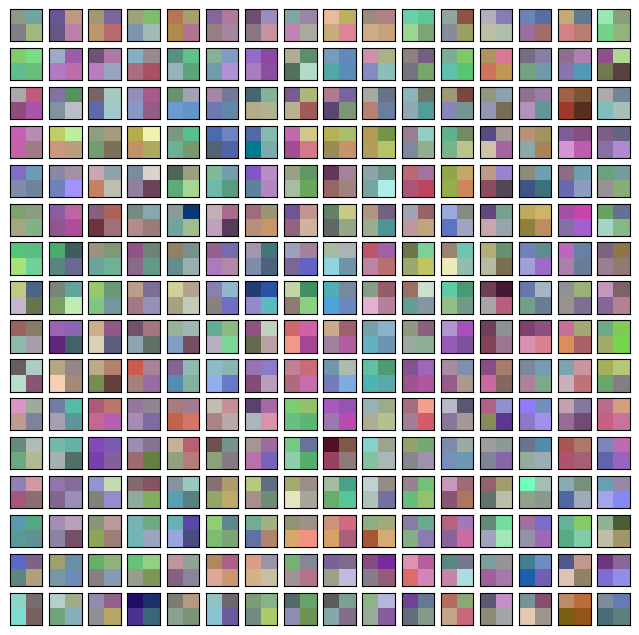

In [10]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)


Even though we did not train the network to convergence, we can notice that different patches show different patterns. Some share similarity with others while some are very different. These visualizations are more salient with larger image sizes.

Similarly, we can visualize the raw convolution kernels. This can help us understand the patterns to which a given kernel is receptive.

5 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd64b1ba7d0>
12 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd64b102380>
19 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd6480d7130>
26 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd6480ea020>
33 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd64810ee60>
40 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd6481218a0>
47 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd6480e81f0>
54 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7bd64815b160>


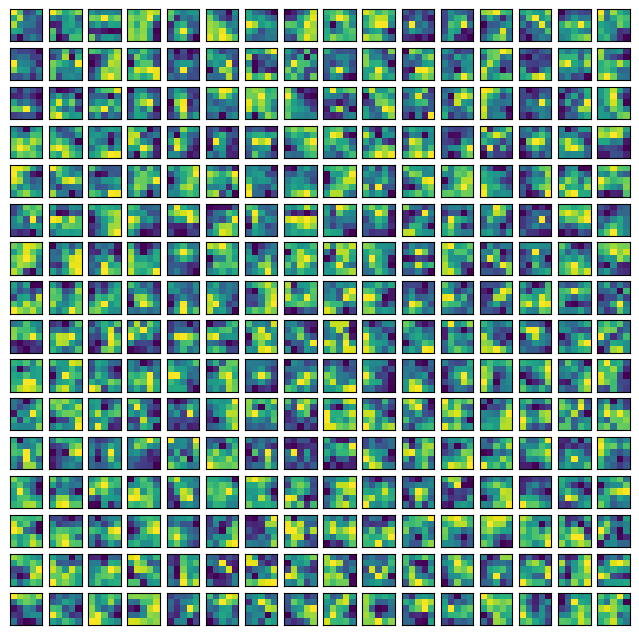

In [11]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

We see that different filters in the kernel have different locality spans, and this pattern is likely to evolve with more training.